<a href="https://colab.research.google.com/github/itaborai83/ecd221-ML-exercicio-03/blob/main/Exerc%C3%ADcio_3_Problemas_de_Regress%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Especialização em Ciência de Dados - PUC-Rio
# Machine Learning
## Exercício 3: Problemas de Regressão



---

**Aluno(s):**

- Alexandre Carboni da Silva

- Agnello Hupp

- Carlos Andrey Gois de Oliveira

- Daniel Lemos Itaboraí

- Rafaela Schifino Azevedo

- Renan Giordano Sfirri
---



https://archive.ics.uci.edu/ml/datasets/auto+mpg

<<<Explicar o dataset e as variáveis aqui>>>

## Instalando dependências e importando pacotes

In [94]:
# imports
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Bibliotecas dos algoritmos de regressão
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

# Bibliotecas das métricas de regressão
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# transformador de colunas, usado para tratamento das variáveis
from sklearn.compose import ColumnTransformer

# redução de dimensionalidade
from sklearn.decomposition import PCA


In [42]:
# setup ambiente

# supressão de warnings
import warnings
warnings.filterwarnings("ignore")

# configura pandas para exibição de apenas duas casas decimais nas variaveis
pd.set_option('display.float_format', lambda x: '%0.2f' % x)

# configura cores do Seaborn
sns.set()

In [90]:
# constantes

# o data set original encontra-se em https://archive.ics.uci.edu/ml/datasets/auto+mpg
# foi preciso corrigir a grafia de vários carros, pois foi introduzida uma variável
# nova chamada "make", contendo o fabricante do veículo
DATA_URL                    = f"https://raw.githubusercontent.com/itaborai83/ecd221-ML-exercicio-03/main/auto-mpg.data"
FIELD_SEPARATOR             = "\s+"
IMPORT_COLUMN_NAMES         = [
    "mpg"                   # mpg - continuous
,   "cyls"                  # cylinders - multi-valued discrete
,   "dsplcmnt"              # displacement - continuous
,   "hp"                    # horse power - continuous
,   "weight"                # weight - continuous
,   "acc"                   # acceleratoin - continuous
,   "year"                  # model year - multi-valued discrete
,   "origin"                # origin - multi-valued discrete -> 1 - "america" / 2 - "europe" / 3 - "asia"
,   "name"                  # car name - string (unique for each instance)
]  
COLUMN_NAMES              = [
    "cyls"                  # cylinders - multi-valued discrete
,   "dsplcmnt"              # displacement - continuous
,   "hp"                    # horse power - continuous
,   "weight"                # weight - continuous
,   "acc"                   # acceleratoin - continuous
,   "year"                  # model year - multi-valued discrete
,   "origin"                # origin - multi-valued discrete -> 1 - "america" / 2 - "europe" / 3 - "asia"
,   "make"                  # car make - string
,    "mpg"                  # mpg - continuous
]
TARGET_VARIABLE             = "mpg"
NUMERIC_FEATURES            = ["cyls", "dsplcmnt", "hp", "weight", "acc", "year", "mpg"]
NUMERIC_FEATURES_NO_TARGET  = ["cyls", "acc", "year"]
LOG_NUMERIC_FEATURES_NO_TARGET = ["dsplcmnt", "hp", "weight"]
CATEGORICAL_FEATURES        = ["origin", "make"]
TEST_SIZE_PCT               = 0.2
SCORING_METHOD              = 'neg_mean_squared_error' # MSE
RANDOM_STATE                = 42
N_SPLITS                    = 10
NUMBER_OF_RANDOM_TRIALS     = 1000
RETURN_TRAIN_SCORE          = False
OUTPUT_TRAINING_FILE        = "RandomizedSearchCV.xlsx"


## Importação de Dados

In [44]:
# lê o arquivo csv
auto_df = pd.read_csv(DATA_URL, names=IMPORT_COLUMN_NAMES, sep=FIELD_SEPARATOR, skiprows=0) # Carga do Dataset

# extrai o nome do fabricante na variável make
# (em inglês usa-se a expressão car make and model para se referir ao fabricante e modelo.)
def extract_car_make(car_name):
  name_parts = car_name.split()
  make = name_parts[0]
  return make
car_names = auto_df["name"]
auto_df["make"] = [extract_car_make(car_name) for car_name in car_names]

# remove o nome do carro
del auto_df["name"]

# move a variável target para o final do dataset
mpg = auto_df[TARGET_VARIABLE]
del auto_df[TARGET_VARIABLE]
auto_df[TARGET_VARIABLE] = mpg

In [45]:
# Imputação de dados faltantes do atributo hp - horsepower 
# usando a mediana por origem
auto_df.replace("?", np.nan, inplace=True)
# separando o data frame por categoria
auto_df_origin_1 = auto_df[ auto_df["origin"] == 1].copy(deep=True)
auto_df_origin_2 = auto_df[ auto_df["origin"] == 2].copy(deep=True)
auto_df_origin_3 = auto_df[ auto_df["origin"] == 3].copy(deep=True)

# removendo valores faltantes dos data frames a serem usados para cálculo das medianas
auto_df_origin_1_drop_na = auto_df_origin_1.dropna()
auto_df_origin_2_drop_na = auto_df_origin_2.dropna()
auto_df_origin_3_drop_na = auto_df_origin_3.dropna()

# Cálculo das Medianas dos atributos com valores faltantes
median_hp_origin_1 = auto_df_origin_1_drop_na["hp"].median()
median_hp_origin_2 = auto_df_origin_2_drop_na["hp"].median()
median_hp_origin_3 = auto_df_origin_3_drop_na["hp"].median()

# Substituicao dos valores faltantes pela mediana
auto_df_origin_1[ "hp" ].fillna(median_hp_origin_1, inplace=True)
auto_df_origin_2[ "hp" ].fillna(median_hp_origin_2, inplace=True)
auto_df_origin_3[ "hp" ].fillna(median_hp_origin_3, inplace=True)

# concatenação dos data frames 
auto_df = pd.concat([auto_df_origin_1, auto_df_origin_2, auto_df_origin_3])

# exclusão de variáveis que não serão mais utilizadas
del auto_df_origin_1
del auto_df_origin_2
del auto_df_origin_3
del auto_df_origin_1_drop_na
del auto_df_origin_2_drop_na
del auto_df_origin_3_drop_na
del median_hp_origin_1
del median_hp_origin_2
del median_hp_origin_3

# converte o tipo da coluna imputada para float
auto_df["hp"] = auto_df["hp"].astype(float)


In [46]:
auto_df.tail(15)

,cyls,dsplcmnt,hp,weight,acc,year,origin,make,mpg
355,4,107.00,75.00,2210.00,14.40,81,3,honda,33.70
356,4,108.00,75.00,2350.00,16.80,81,3,toyota,32.40
357,4,119.00,100.00,2615.00,14.80,81,3,datsun,32.90
358,4,120.00,74.00,2635.00,18.30,81,3,mazda,31.60
361,6,168.00,116.00,2900.00,12.60,81,3,toyota,25.40
362,6,146.00,120.00,2930.00,13.80,81,3,datsun,24.20
376,4,91.00,68.00,2025.00,18.20,82,3,mazda,37.00
377,4,91.00,68.00,1970.00,17.60,82,3,mazda,31.00
380,4,120.00,88.00,2160.00,14.50,82,3,nissan,36.00
381,4,107.00,75.00,2205.00,14.50,82,3,honda,36.00


In [47]:
auto_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 0 to 390
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   cyls      398 non-null    int64  
 1   dsplcmnt  398 non-null    float64
 2   hp        398 non-null    float64
 3   weight    398 non-null    float64
 4   acc       398 non-null    float64
 5   year      398 non-null    int64  
 6   origin    398 non-null    int64  
 7   make      398 non-null    object 
 8   mpg       398 non-null    float64
dtypes: float64(5), int64(3), object(1)
memory usage: 31.1+ KB


In [48]:
# descreve as variáveis numéricas
auto_df.describe()


,cyls,dsplcmnt,hp,weight,acc,year,origin,mpg
count,398.00,398.00,398.00,398.00,398.00,398.00,398.00,398.00
mean,5.45,193.43,104.33,2970.42,15.57,76.01,1.57,23.51
std,1.70,104.27,38.25,846.84,2.76,3.70,0.80,7.82
min,3.00,68.00,46.00,1613.00,8.00,70.00,1.00,9.00
25%,4.00,104.25,76.00,2223.75,13.83,73.00,1.00,17.50
50%,4.00,148.50,94.50,2803.50,15.50,76.00,1.00,23.00
75%,8.00,262.00,125.00,3608.00,17.18,79.00,2.00,29.00
max,8.00,455.00,230.00,5140.00,24.80,82.00,3.00,46.60


In [49]:
# descreve as variáveis numéricas agrupadas por origin
origin_df = auto_df.groupby(['origin'])
#	cylinders displacement	weight	acceleration	model_year	mpg
numerical_columns = ["cyls", "dsplcmnt", "hp", "weight", "acc", "year", "origin", "make", "mpg" ]

for numerical_column in numerical_columns:
  print("\n\n--", numerical_column, "--")
  print(origin_df[numerical_column].describe())



-- cyls --
        count  mean  std  min  25%  50%  75%  max
origin                                           
1      249.00  6.25 1.66 4.00 4.00 6.00 8.00 8.00
2       70.00  4.16 0.50 4.00 4.00 4.00 4.00 6.00
3       79.00  4.10 0.59 3.00 4.00 4.00 4.00 6.00


-- dsplcmnt --
        count   mean   std   min    25%    50%    75%    max
origin                                                      
1      249.00 245.90 98.50 85.00 151.00 250.00 318.00 455.00
2       70.00 109.14 22.58 68.00  92.25 104.50 121.00 183.00
3       79.00 102.71 23.14 70.00  86.00  97.00 119.00 168.00


-- hp --
        count   mean   std   min   25%    50%    75%    max
origin                                                     
1      249.00 118.82 39.61 52.00 88.00 105.00 150.00 230.00
2       70.00  80.44 19.88 46.00 70.00  76.50  90.00 133.00
3       79.00  79.84 17.82 52.00 67.00  75.00  95.00 132.00


-- weight --
        count    mean    std     min     25%     50%     75%     max
origin              

Existe um desbalanceamento do dataset, pois 62.5% dos carros são fabricados nos Estados Unidos(origin=1).

Os carros fabricados na Europa (origin=2) e Ásia(origin=3) possuem um melhor consumo que os carros fabricados nos Estados Unidos(origin=1).



In [50]:
auto_df.skew()

cyls       0.53
dsplcmnt   0.72
hp         1.10
weight     0.53
acc        0.28
year       0.01
origin     0.92
mpg        0.46
dtype: float64

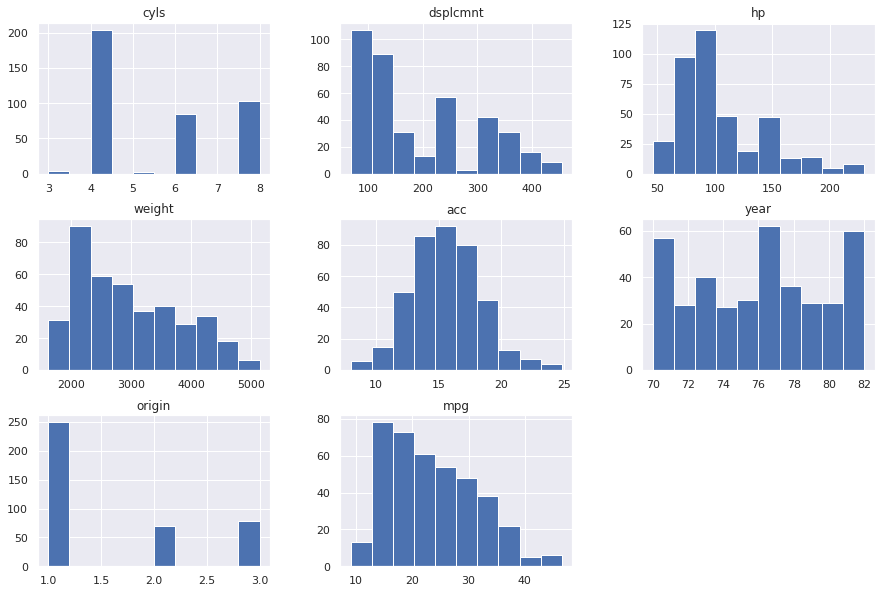

In [51]:
# Histograma
auto_df.hist(figsize = (15,10))
plt.show() # opcional no Colab, usando aqui ele substitui o ;

A variável **acc** parece seguir uma distribuição normal.

**year** parece seguir uma distribuição uniforme.

A **dsplcmnt** aparenta estar distribuída exponencialmente, mas com "buracos".

**hp**, **weight** e **mpg** parece seguir distribuições lognormais

As variáveis **dsplcmnt**, **hp** e **weight** serão tratadas com uma transformação logarítimica no pipeline.

A variável **origin** é categórica, nela podemos observar a maior prevalência de carros fabricados nos Estados Unidos(origin=1).

In [52]:

# cria uma cópia do data frame sem a variável car_make (que é categórica)
all_except_make = auto_df.columns.difference(["make"])
work_df = auto_df[all_except_make]

# a coeficiente de correlação de kendall é aconselhado para casos com poucos dados e com muitos empates no rankeamento
correlations_df = work_df.corr("kendall") 
print(correlations_df)


           acc  cyls  dsplcmnt    hp   mpg  origin  weight  year
acc       1.00 -0.37     -0.35 -0.48  0.30    0.17   -0.27  0.20
cyls     -0.37  1.00      0.79  0.68 -0.69   -0.55    0.74 -0.27
dsplcmnt -0.35  0.79      1.00  0.71 -0.68   -0.57    0.80 -0.22
hp       -0.48  0.68      0.71  1.00 -0.68   -0.41    0.70 -0.28
mpg       0.30 -0.69     -0.68 -0.68  1.00    0.47   -0.69  0.41
origin    0.17 -0.55     -0.57 -0.41  0.47    1.00   -0.50  0.14
weight   -0.27  0.74      0.80  0.70 -0.69   -0.50    1.00 -0.20
year      0.20 -0.27     -0.22 -0.28  0.41    0.14   -0.20  1.00


A variável target, **mpg** (milhas por galão de combustível), está negativamente correlacionada com as variáveis **cyls**, **weight**, **dsplcmnt** e **hp**, indicando que o consumo do carro aumenta com o aumento do peso ou da potência do mesmo.

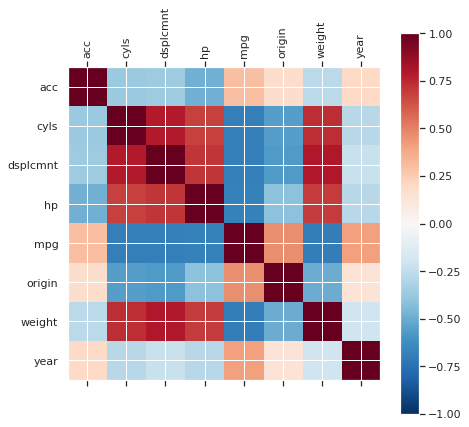

In [53]:

# Cria uma figura
fig = plt.figure(figsize = (7, 7))
# Adiciona o gráfico
ax = fig.add_subplot(111)
# Plota as correlações
cax = ax.matshow(correlations_df, vmin=-1, vmax=1,  cmap=cm.get_cmap('RdBu_r')) #_r colormap invertido
# Adiciona a barra de cores
fig.colorbar(cax)
# Define o tamanho do quadrado
ticks = np.arange(0, len(work_df.columns), 1)
# Seta as labels dos eixos x e y
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(work_df.columns, rotation='vertical')
ax.set_yticklabels(work_df.columns)
# Mostra o gráfico
plt.show()


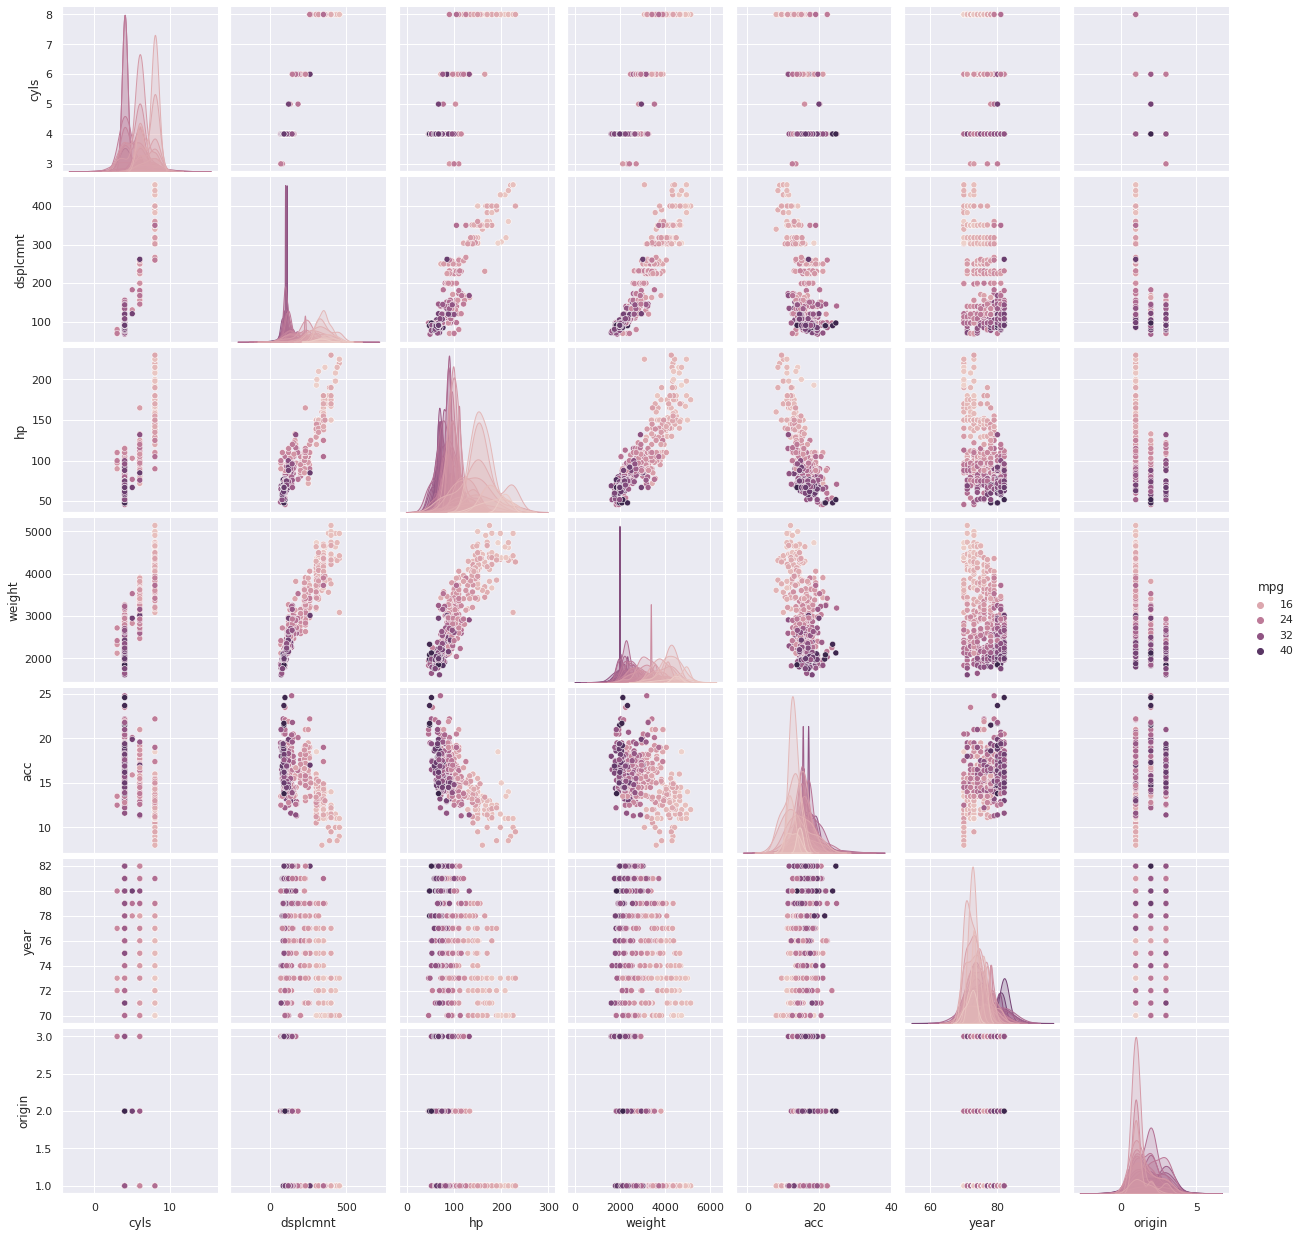

In [54]:
sns.pairplot(
    auto_df
,   hue="mpg"
,   height = 2.5
);

## Preparação dos Dados para regressão



In [55]:
# configurando a validação cruzada
kfold = KFold(
    n_splits      = N_SPLITS
,   shuffle       = True
,   random_state  = RANDOM_STATE
)

# cria X e y
all_but_target = all_except_make = auto_df.columns.difference([TARGET_VARIABLE])
work_df = auto_df[all_but_target]
target_df = auto_df[TARGET_VARIABLE]

# particionando em conjuntos de treino e teste, estratificando pela origin
X_train, X_test, y_train, y_test = train_test_split(
    work_df
,   target_df
,   test_size     = TEST_SIZE_PCT
,   random_state  = RANDOM_STATE
,   stratify      = auto_df["origin"]
)

x_train_df = pd.DataFrame(X_train, columns=all_but_target)
x_test_df = pd.DataFrame(X_test, columns=all_but_target)
y_train_df = pd.DataFrame(y_train, columns=["mpg"])
y_test_df = pd.DataFrame(y_test, columns=["mpg"])
print(x_train_df.info())
print(y_train_df.info())
print(x_test_df.info())
print(y_test_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318 entries, 319 to 12
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   acc       318 non-null    float64
 1   cyls      318 non-null    int64  
 2   dsplcmnt  318 non-null    float64
 3   hp        318 non-null    float64
 4   make      318 non-null    object 
 5   origin    318 non-null    int64  
 6   weight    318 non-null    float64
 7   year      318 non-null    int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 22.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 318 entries, 319 to 12
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mpg     318 non-null    float64
dtypes: float64(1)
memory usage: 5.0 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 69 to 67
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  ---

In [64]:
# configuração do pipeline

# Os transformadores numéricos são utilizado spara processamento de todas as variáveis não categóricas.
numeric_transformer = Pipeline([
  ("scaler", StandardScaler())    
])

# as variáveis dsplcmnt, hp e weight sofrerão transformação logarítmica
log_numeric_transformer = Pipeline([
  ("log", FunctionTransformer(np.log1p, validate=True)),
  ("scaler", StandardScaler())    
])

# O transformador categórico é utilizado para processamento de todas as variáveis
# categóricas. É possível que algum valor de uma variável categórica ("make")
# esteja presente no conjunto de treino e não esteja presente no conjunto de testes.
# Nestes casos, o valor precisa ser imputado

categorical_transformer = Pipeline([
  ("imputer", SimpleImputer(strategy="most_frequent")), 
  ("encoder", OneHotEncoder(sparse=False, handle_unknown="ignore")),
])

# configuração do transformador de colunas.
# ele opera em dataframes sem problemas
column_transformer = ColumnTransformer(
  transformers = [
      ("num", numeric_transformer,     NUMERIC_FEATURES_NO_TARGET),
      ("log", log_numeric_transformer, LOG_NUMERIC_FEATURES_NO_TARGET),
      ("cat", categorical_transformer, CATEGORICAL_FEATURES)
    ],
    # importante usar passthrough quando nem todos os atributos forem processados
    remainder="passthrough" 
)

# Configuração do pipeline
# Este pipelie será ajustado diversas vezes durante o processo de otimização
# dos hiper parâmetros.
pipeline = Pipeline([
    # a primeira fase consiste no pré-processamento das variáveis numéricas e categóricas
    ("preprocessor", column_transformer),
    # redução de dimesionalidade
    ("reduce_dim", PCA()),
    # O algoritmo de regressão e seus parâmetros serão configurados via gridsearch
    ("regression", SVR())
])
pipeline.fit(x_train_df, y_train_df)
print(pipeline)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['cyls', 'acc', 'year']),
                                                 ('log',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       validate=True)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dsplcmnt', 'hp', 'weight']),
                   

In [98]:
# CUIDADO!!!
# Este código é muito lento.
# Evite reexecutá-lo se não for preciso (aprox. 20 minutos)

# devido ao grande número de combinações existentes,
# foi preciso substituir a classe GridSearchCV pela
# classe RandomizedSearchCV que não pode garantir
# que a otimalidade da melhor resposta
log_transform = FunctionTransformer(np.log1p, validate=True)

# Realiza a busca por hiperparâmetros
param_grid = [
  # Ridge e Lasso
  {
    "preprocessor__num__scaler"    : ["passthrough", MinMaxScaler(), StandardScaler()],
    "preprocessor__log__scaler"    : ["passthrough", MinMaxScaler(), StandardScaler()],
    "preprocessor__log__log"       : ["passthrough", log_transform],
    "reduce_dim"                   : ["passthrough", PCA(n_components=3), PCA(n_components=5)],
    "regression"                   : [Ridge(), Lasso()],
    "regression__alpha"            : [0.01, 0.5, 1, 5, 10]
  },
  # ElasticNet
  {
    "preprocessor__num__scaler"    : ["passthrough", MinMaxScaler(), StandardScaler()],
    "preprocessor__log__scaler"    : ["passthrough", MinMaxScaler(), StandardScaler()],
    "preprocessor__log__log"       : ["passthrough", log_transform],
    "reduce_dim"                   : ["passthrough", PCA(n_components=3), PCA(n_components=5)],
    "regression"                   : [ElasticNet()],
    "regression__alpha"            : [0.01, 0.5, 1, 5, 10],
    "regression__l1_ratio"         : [0.25, 0.50, 0.75]
  },  
  # KNeighborsRegressor
  {
    "preprocessor__num__scaler"     : ["passthrough", MinMaxScaler(), StandardScaler()],
    "preprocessor__log__scaler"     : ["passthrough", MinMaxScaler(), StandardScaler()],
    "preprocessor__log__log"        : ["passthrough", log_transform],
    "reduce_dim"                   : ["passthrough", PCA(n_components=3), PCA(n_components=5)],
    "regression"                    : [KNeighborsRegressor()],
    "regression__n_neighbors"       : [3, 5, 7, 9, 11, 13, 15, 17, 19],
    "regression__metric"            : ["minkowski"], # minkowski é parametrizável com p
    "regression__p"                 : [1, 2] # 1 = manhattan, 2 = euclidean
  },
  # DecisionTreeRegressor
  {
    "preprocessor__num__scaler"     : ["passthrough", MinMaxScaler(), StandardScaler()],
    "preprocessor__log__scaler"     : ["passthrough", MinMaxScaler(), StandardScaler()],
    "preprocessor__log__log"        : ["passthrough", log_transform],
    "reduce_dim"                   : ["passthrough", PCA(n_components=3), PCA(n_components=5)],
    "regression"                    : [ DecisionTreeRegressor()],
    "regression__criterion"         : ['mse', 'mae'], # função para medir a qualidade de uma divisão
    "regression__max_depth"         : [3, 5, 10, 15],
    "regression__min_samples_leaf"  : [3, 5, 7]
  },
  # SVR
  {
    "preprocessor__num__scaler"     : ["passthrough", MinMaxScaler(), StandardScaler()],
    "preprocessor__log__scaler"     : ["passthrough", MinMaxScaler(), StandardScaler()],
    "reduce_dim"                   : ["passthrough", PCA(n_components=3), PCA(n_components=5)],
    "preprocessor__log__log"        : ["passthrough", log_transform],
    "regression"                    : [ SVR()],
    "regression__C"                 : [0.1, 0.5, 1.0, 1.5, 2.0], # rigidez da margem
    "regression__kernel"            : ['poly', 'rbf'], # função kernel
  },
  # RandomForestRegressor
  {
    "preprocessor__num__scaler"     : ["passthrough"],
    "preprocessor__log__scaler"     : ["passthrough"],
    "reduce_dim"                    : ["passthrough"],
    "preprocessor__log__log"        : ["passthrough", log_transform],
    "regression"                    : [ RandomForestRegressor()],
    "regression__n_estimators"      : [50, 100, 200],
    "regression__min_samples_split" : [5, 7, 9],
    "regression__bootstrap"         : [True, False]
  },
  # HistGradientBoostingRegressor
  {
    "preprocessor__num__scaler"     : ["passthrough", MinMaxScaler(), StandardScaler()],
    "preprocessor__log__scaler"     : ["passthrough", MinMaxScaler(), StandardScaler()],
    "reduce_dim"                    : ["passthrough"],
    "preprocessor__log__log"        : ["passthrough", log_transform],
    "regression"                    : [ HistGradientBoostingRegressor()],
    "regression__max_iter"          : [50, 100, 200],
    "regression__min_samples_leaf"  : [10, 15, 20],
    "regression__max_bins"          : [50, 100, 200],
  },
]
grid = RandomizedSearchCV(
    estimator           = pipeline
,   param_distributions = param_grid
,   scoring             = SCORING_METHOD
,   cv                  = kfold
,   n_iter              = NUMBER_OF_RANDOM_TRIALS
,   return_train_score  = RETURN_TRAIN_SCORE
)
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.best_params_)
results_df = pd.DataFrame(grid.cv_results_)
results_df.head(50)
results_df.to_excel(OUTPUT_TRAINING_FILE)



-7.944560153584517
{'regression__min_samples_leaf': 15, 'regression__max_iter': 200, 'regression__max_bins': 100, 'regression': HistGradientBoostingRegressor(max_bins=100, max_iter=200, min_samples_leaf=15), 'reduce_dim': 'passthrough', 'preprocessor__num__scaler': MinMaxScaler(), 'preprocessor__log__scaler': MinMaxScaler(), 'preprocessor__log__log': 'passthrough'}


In [99]:
# exibe as top 20 parametrizações
import pprint
import json
results_df.sort_values("mean_test_score", inplace=True, ascending=False)
results = []
for i, row in enumerate(results_df.itertuples()):
  if i >= 20:
      break
  params = row.params.copy()
  params["mean_test_score"] = row.mean_test_score
  params["std_test_score"] = row.std_test_score
  results.append(list(params.items()))

pprint.pprint(
    results
,   indent     = 4
,   width      = 120    
)

[   [   ('regression__min_samples_leaf', 15),
        ('regression__max_iter', 200),
        ('regression__max_bins', 100),
        ('regression', HistGradientBoostingRegressor(max_bins=100, max_iter=200, min_samples_leaf=15)),
        ('reduce_dim', 'passthrough'),
        ('preprocessor__num__scaler', MinMaxScaler()),
        ('preprocessor__log__scaler', MinMaxScaler()),
        ('preprocessor__log__log', 'passthrough'),
        ('mean_test_score', -7.944560153584517),
        ('std_test_score', 3.6616454637224503)],
    [   ('regression__min_samples_leaf', 15),
        ('regression__max_iter', 200),
        ('regression__max_bins', 100),
        ('regression', HistGradientBoostingRegressor(max_bins=100, max_iter=200, min_samples_leaf=15)),
        ('reduce_dim', 'passthrough'),
        ('preprocessor__num__scaler', StandardScaler()),
        ('preprocessor__log__scaler', MinMaxScaler()),
        ('preprocessor__log__log', FunctionTransformer(func=<ufunc 'log1p'>, validate=True)),
 

HistGradientBoostingRegressor ocupa todos os resultados do top 20 melhores parametrizações.

a planilha RandomizedSearchCV.xlsx detalha os 1000 experimentos aleatórios executados pela classe RandomizedSearchCV, detalhando tanto os parâmetros e algoritmos além das performance de teste das validações cruzadas realizadas. Caso deseje-se as métricas de treino, é preciso configurar o parâmetro RETURN_TRAIN_SCORE para True.

## Modelo Final

In [101]:
# a busca dos hiper parâmetros já treina o melhor estimador usando os dados de
# treino disponíveis ao término da execução
model = grid.best_estimator_
print(model)
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['cyls', 'acc', 'year']),
                                                 ('log',
                                                  Pipeline(steps=[('log',
                                                                   'passthrough'),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['dsplcmnt', 'hp', 'weight']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                  

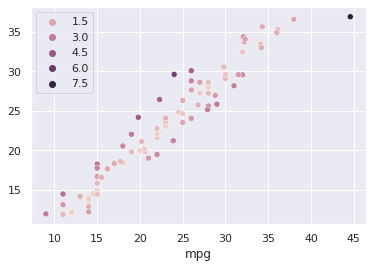

In [104]:
# gráfico de dispersão onde x=mpg e y=predição de mpg os pontos são coloridos pelo erro absoluto
errors = []
for y, prediction in zip(y_test, predictions):
    errors.append( abs(y-prediction) )
sns.scatterplot(
    x=y_test,
    y=predictions,
    hue=errors
)

**Agora pesquise outras bibliotecas, modelos de regressão ou funcionalidades (não estudados em sala) e aplique-os no problema. Lembre-se que quanto mais você pesquisar e treinar, mais irá aprender.**

Para esse exerício, aprendemos a utilizar o Pipeline de maneiras mais efetiva, adicionando no mesmo diversas transformações, como a realização ou não de redução de dimensionalidade usando PCA, a transformação logarítmica ou não de um subconjunto de variáveis e o uso dos transformadores de Colunas (ColumnTransformer) que possibilita uma maior flexibilidade no Pipeline.

Dado o aumento de complexidade no Pipeline e o elevado número de algoritmos, passamos a usar a RandomizedSearchCV ao invés de GridSearchCV, que realiza uma busca aleatória do espaço dos hiper-parâmetros ao invés de uma busca exaustiva.

O exercício também nos mostrou o quão efetivo o algoritmo **HistGradientBoostingRegressor** é, tendo completamente dominado os 20 melhores resultados.


**O que você aprendeu sobre o problema de regressão deste dataset?**

Este dataset é relativamente simples, apresentando alguns relacionamentos (quase lineares) com alto poder de explicação da variável target (vide gráfico **weight** x **hp**).

Ele trouxe uma oportunidade para realização de feature engineering através da criação de uma variável categórica indicando o fabricante do carro (variável **make**).

É curioso observar numericamente como os carros fabricados nos Estados Unidos entre 1970 a 1982 possuíam um consumo significativamente maior do que os fabricantes europeus e asiáticos. O dataset parece capturar um momento de transição na indústria automobílistica no qual a supremacia americana começa a ser erodida por fabricantes de outros continentes, oferecendo modelos mais econônmicos e mais alinhados às necessidades de parcelas maiores da população